# Gradients and Automatic Differentiation

Resource: [TensorFlow Guide](https://www.tensorflow.org/guide/autodiff)

Automatic differentiation is useful for implementing machine learning algorithms such as backpropagation for training neural networks.

In this guide, you will explore ways to compute gradients with TensorFlow, especially in eager execution.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## Computing Gradients

To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients.

TensorFlow provides the tf.GradientTape API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually tf.Variables. TensorFlow "records" relevant operations executed inside the context of a tf.GradientTape onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

### Gradients on scalar

In [ ]:
x = tf.Variable(3.0)

# record relevant operations inside tf.GradientTape
with tf.GradientTape() as tape:
  y = x**2

# calculate the gradient of some target relative to some source
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

### Gradients on tensors

In [ ]:
w = tf.Variable(tf.random.normal((4, 3)), name = 'w')
b = tf.Variable(tf.zeros(3, dtype = tf.float32), name = 'b')
x = [[1., 2., 3., 4.]]

with tf.GradientTape(persistent = True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y ** 2)

dl_dw, dl_db = tape.gradient(loss, (w, b))

In [ ]:
print(dl_dw)
print(dl_db)

tf.Tensor(
[[ -0.39602327  -7.984413     7.115556  ]
 [ -0.79204655 -15.968826    14.231112  ]
 [ -1.1880698  -23.95324     21.346668  ]
 [ -1.5840931  -31.937653    28.462223  ]], shape=(4, 3), dtype=float32)
tf.Tensor([-0.39602327 -7.984413    7.115556  ], shape=(3,), dtype=float32)


In [ ]:
grad = tape.gradient(loss, {'w': w, 'b': b})

print(grad['w'])
print(grad['b'])

tf.Tensor(
[[ -0.39602327  -7.984413     7.115556  ]
 [ -0.79204655 -15.968826    14.231112  ]
 [ -1.1880698  -23.95324     21.346668  ]
 [ -1.5840931  -31.937653    28.462223  ]], shape=(4, 3), dtype=float32)
tf.Tensor([-0.39602327 -7.984413    7.115556  ], shape=(3,), dtype=float32)


### Gradients on a model

In [ ]:
layer = tf.keras.layers.Dense(2, activation = 'relu')
x = tf.constant([[1., 2., 3., 4.]])

with tf.GradientTape() as tape:
  y = layer(x)
  loss = tf.reduce_mean(y**2)

grad = tape.gradient(loss, layer.trainable_variables)

In [ ]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}')
  print(f'{g}\n\n')

dense/kernel:0
[[ 4.7539253  0.       ]
 [ 9.507851   0.       ]
 [14.261776   0.       ]
 [19.015701   0.       ]]


dense/bias:0
[4.7539253 0.       ]




## Controling what to watch

The default behavior is to record all operations after accessing a trainable tf.Variable. The reasons for this are:

- The tape needs to know which operations to record in the forward pass to calculate the gradients in the backwards pass.
- The tape holds references to intermediate outputs, so you don't want to record unnecessary operations.
- The most common use case involves calculating the gradient of a loss with respect to all a model's trainable variables.


### Default behaviour

For example, the following fails to calculate a gradient because the tf.Tensor is not "watched" by default, and the tf.Variable is not trainable:

In [ ]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2) + x3

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


In [ ]:
[var.name for var in tape.watched_variables()]

['x0:0']

### Watching a tensor constant

In [ ]:
x = tf.constant(5.3)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x ** 2

dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

10.6


### Disable watching all variables

In [ ]:
x0 = tf.Variable(0.)
x1 = tf.Variable(10.)

with tf.GradientTape(watch_accessed_variables = False) as tape:
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1 ** 2
  ys = tf.reduce_sum(y)

grad = tape.gradient(y, {'x0': x0, 'x1': x1})

In [ ]:
print(grad)

{'x0': None, 'x1': None}


In [ ]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

In [ ]:
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


### Intermediate Results

You can also request gradients of the output with respect to intermediate values computed inside the tf.GradientTape context.

By default, the resources held by a GradientTape are released as soon as the GradientTape.gradient method is called. To compute multiple gradients over the same computation, create a gradient tape with persistent=True. This allows multiple calls to the gradient method as resources are released when the tape object is garbage collected.

In [ ]:
x = tf.constant([1., 3.])

with tf.GradientTape(persistent = True) as tape:
  tape.watch(x)
  y = x * x
  z = 3 * y ** 3

print(tape.gradient(z, x))
print(tape.gradient(z, y))
print(tape.gradient(y, x))

del tape

tf.Tensor([  18. 4374.], shape=(2,), dtype=float32)
tf.Tensor([  9. 729.], shape=(2,), dtype=float32)
tf.Tensor([2. 6.], shape=(2,), dtype=float32)


## Non-scalar targets

A gradient is fundamentally an operation on a scalar. Thus, if you ask for the gradient of multiple targets, the result for each source is:

- The gradient of the sum of the targets, or equivalently
- The sum of the gradients of each target.

In [ ]:
x = tf.Variable(2.)
with tf.GradientTape(persistent = True) as tape:
  y0 = x ** 2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())
print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

4.0
-0.25
3.75


In [ ]:
x = tf.Variable(2.)
with tf.GradientTape() as tape:
  y = x ** 2 *[3., 4.]

dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

28.0


For an element-wise calculation, the gradient of the sum gives the derivative of each element with respect to its input-element, since each element is independent.

In [ ]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

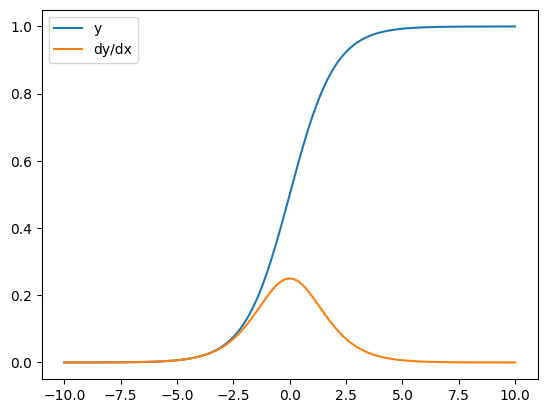

In [ ]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()

## Control Flow

Because a gradient tape records operations as they are executed, Python control flow is naturally handled (for example, if and while statements).

The control statements themselves are not differentiable, so they are invisible to gradient-based optimizers.

In [ ]:
x = tf.constant(1.)
v0 = tf.Variable(3.)
v1 = tf.Variable(2.)

with tf.GradientTape(persistent = True) as tape:
  tape.watch(x)
  if x > 0.0:
    y = v0
  else:
    y = v1 ** 2

dy_dx = tape.gradient(y, x)
dy_dv = tape.gradient(y, {'v0': v0, 'v1': v1})

print(dy_dx)
print(dy_dv['v0'])
print(dy_dv['v1'])

None
tf.Tensor(1.0, shape=(), dtype=float32)
None


In [ ]:
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1

  print(type(x).__name__, ":", tape.gradient(y, x))
  x = x + 1   # This should be `x.assign_add(1)`
  # x.assign_add(1)
  # x.assign(x + 1)

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None
